# **Libraries & Constants**

In [125]:
from tqdm import tqdm
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import SubsetRandomSampler, ConcatDataset
from torch.utils.data import random_split
from torchvision.io import read_image
from torchvision import transforms as t
from torchvision.transforms import functional as F

# cross-validaion and evaluation tools
from sklearn.metrics import classification_report

import cv2
import pandas as pd
import tensorflow as tf
import numpy as np
import PIL
from matplotlib import pyplot as plt
import os
from copy import deepcopy
from google.colab import drive

In [ ]:
drive.mount('/content/drive')
data_path = "/content/drive/MyDrive/AI Projects/Meta-learning vision project/mhsma-dataset sperm images/mhsma/"

# **Preprocessing**

In [96]:
# import dataset from path
x_train_ = np.load(data_path + 'x_128_train.npy')
x_dev_ = np.load(data_path + 'x_128_valid.npy')
x_test_ = np.load(data_path + 'x_128_test.npy')

x_shape = x_train_.shape
x_train = x_train_.reshape(x_train_.shape[0], x_shape[1], x_shape[2])
x_dev = x_dev_.reshape(x_dev_.shape[0], x_shape[1], x_shape[2])
x_test = x_test_.reshape(x_test_.shape[0], x_shape[1], x_shape[2])

y_acrosome_train = np.load(data_path + 'y_acrosome_train.npy')
y_acrosome_dev = np.load(data_path + 'y_acrosome_valid.npy')
y_acrosome_test = np.load(data_path + 'y_acrosome_test.npy')

y_head_train = np.load(data_path + 'y_head_train.npy').reshape(-1, 1)
y_head_dev = np.load(data_path + 'y_head_valid.npy').reshape(-1, 1)
y_head_test = np.load(data_path + 'y_head_test.npy').reshape(-1, 1)

y_tail_train = np.load(data_path + 'y_tail_train.npy').reshape(-1, 1)
y_tail_dev = np.load(data_path + 'y_tail_valid.npy').reshape(-1, 1)
y_tail_test = np.load(data_path + 'y_tail_test.npy').reshape(-1, 1)

y_vacuole_train = np.load(data_path + 'y_vacuole_train.npy').reshape(-1, 1)
y_vacuole_dev = np.load(data_path + 'y_vacuole_valid.npy').reshape(-1, 1)
y_vacuole_test = np.load(data_path + 'y_vacuole_test.npy').reshape(-1, 1)

In [97]:
print('x_train.shape: ', x_train.shape)
print('x_dev.shape: ', x_dev.shape)
print('x_test.shape: ', x_test.shape)
print('y_acrosome_train.shape: ', y_acrosome_train.shape)

# y = 1 abnormal,  y = 0 normal

x_train.shape:  (1000, 128, 128)
x_dev.shape:  (240, 128, 128)
x_test.shape:  (300, 128, 128)
y_acrosome_train.shape:  (1000,)


Example

1


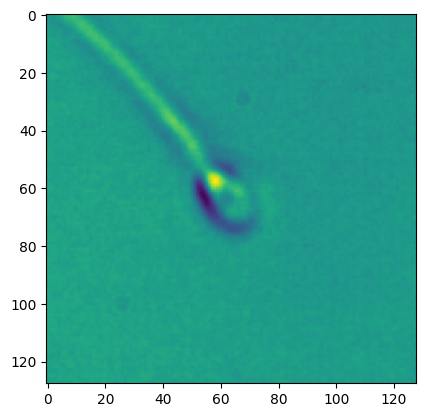

In [98]:
plt.imshow(x_train[30])
print(y_acrosome_train[30])

In [99]:
def convertTo3ChannelImg(img):
  return  np.stack((img, img, img), axis=0) # cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

threeChannelImg = lambda x: np.stack((x, x, x), axis=0)

x_train_3CH = np.array([threeChannelImg(sample) for sample in x_train], dtype=np.float32)
x_test_3CH = np.array([threeChannelImg(sample) for sample in x_test], dtype=np.float32)
x_dev_3CH = np.array([threeChannelImg(sample) for sample in x_dev], dtype=np.float32)

print(x_train_3CH.dtype)
print(x_train_3CH.shape)

float32
(1000, 3, 128, 128)


In [100]:
x_train_tensor = torch.from_numpy(x_train_3CH, )
x_test_tensor = torch.from_numpy(x_test_3CH)
x_dev_tensor = torch.from_numpy(x_dev_3CH)

y_acrosome_train_tensor = torch.from_numpy(y_acrosome_train)
y_acrosome_test_tensor = torch.from_numpy(y_acrosome_test)
y_acrosome_dev_tensor = torch.from_numpy(y_acrosome_dev)

In [101]:
class DatasetPair(Dataset):
  def __init__(self, x, y, transform=None, target_transform=None):
    self.img_labels = y
    self.imgs = x
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self):
    return len(self.img_labels)

  def __getitem__(self, idx):
    image = self.imgs[idx]
    label = self.img_labels[idx]
    # if self.transform:
    #     image = self.transform(image)
    # if self.target_transform:
    #     label = self.target_transform(label)
    return image, label

trainset = DatasetPair(x_train_tensor, y_acrosome_train_tensor)
devset = DatasetPair(x_dev_tensor, y_acrosome_dev_tensor)
testset = DatasetPair(x_test_tensor, y_acrosome_test_tensor)

print('each image size: ', trainset[0][0].shape)
print('each label size: ', trainset[0][1].shape)

each image size:  torch.Size([3, 128, 128])
each label size:  torch.Size([])


In [102]:
print(x_train_tensor.dtype)

print(trainset[0][0].dtype)

torch.float32
torch.float32


In [122]:
def show(dataset, N=5, labels=None, figsize=(20, 20)):
    """ Shows random N samples from the dataset """
    idxs = np.random.randint(0, len(dataset)-1, N)

    fig, axs = plt.subplots(ncols=len(idxs), squeeze=False, figsize=figsize)

    for i, idx in enumerate(idxs):
        sample = dataset[idx]
        if isinstance(sample, tuple): # then it is in the form (x, y)
          sample, label = sample

          if isinstance(label, torch.Tensor):
            label = int(label.item())
          if labels:
            label = labels[label]
          axs[0, i].title.set_text(label)
        axs[0, i].imshow(sample.type(torch.int16).permute(1, 2, 0))
        axs[0, i].set(xticklabels = [], yticklabels = [], xticks = [], yticks = [])

    plt.show()

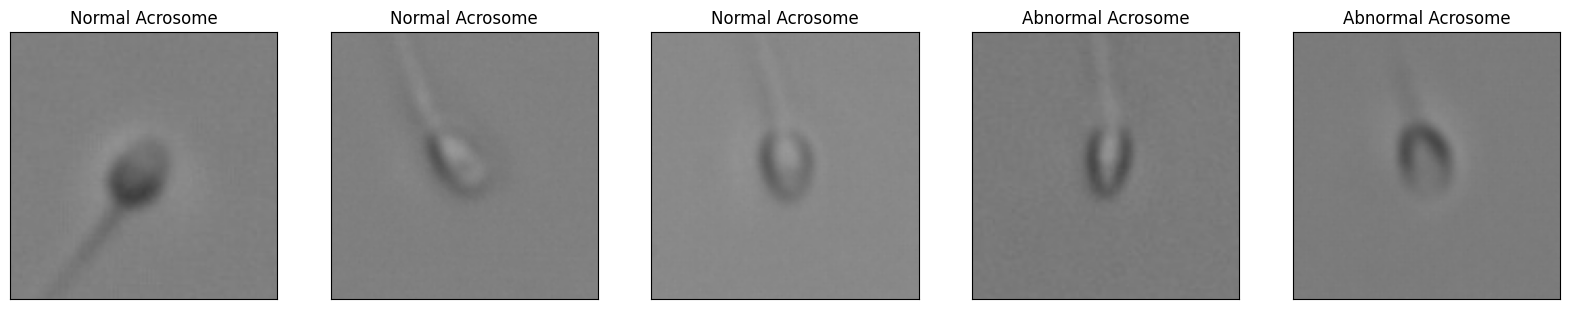

In [123]:
idx_to_labels = {0: "Normal Acrosome", 1: "Abnormal Acrosome"}
show(trainset, labels=idx_to_labels)

# **VGG**

In [ ]:
model = torchvision.models.vgg16()
model.classifier[6] = nn.Linear(4096, 2)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [93]:
class VGGBinaryClassification(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.model = torchvision.models.vgg16(pretrained=True)
        self.model.classifier[6] = nn.Linear(4096, 2)

        unfreeze = ['classifier']
        for layer_name, layer in self.model.named_parameters():
            for name in unfreeze:
                if name in layer_name:
                    layer.requires_grad = True
                    break
                else:
                    layer.requires_grad = False
    
    def forward(self, x):
        return self.model(x)

In [94]:
def evaluate(dataset, model, device='cpu', **dataloader_args):
    dataloader = DataLoader(dataset, **dataloader_args)
    preds = []
    labels = []
    with torch.no_grad():
        model.eval()
        model.to(device)
        
        for x_batch, y_batch in tqdm(dataloader):
            x_batch = x_batch.to(device)
            y_batch = y_batch.tolist()
            
            outs = model(x_batch).detach().cpu()
            predictions = torch.argmax(torch.softmax(outs, 1), 1).tolist()
            
            # extend the `preds` and `labels` lists with predictions and true labels
            preds.extend(predictions)
            labels.extend(y_batch)
            
    report = classification_report(labels, preds, digits = 3)
    report_dict = classification_report(labels, preds, output_dict=True)
    print(report)
    return report_dict

def train(model, loss_fn, 
          train_loader, val_loader,return_model=False,
          device='cpu', lr_adjuster=None, epochs=10):
    
    n_train = len(train_loader.dataset)
    n_val = len(val_loader.dataset)
    
    training_losses = []
    validation_losses = [] 
    
    # initialize the model
    optimizer = get_optimizer(model)

    # pass the model to the given device
    model.to(device)

    print("Number of samples")
    print("Training:", n_train)
    print('Validation:', n_val)
    for epoch in range(epochs):
        # define running losses
        epoch_training_running_loss = 0
        epoch_val_running_loss = 0

        if lr_adjuster:
            lr = lr_adjuster(optimizer, epoch)
        
        bar = tqdm(enumerate(train_loader), total=n_train//train_loader.batch_size)
        # loop through every batch in the training loader
        for batch_idx, (x_batch, y_batch) in bar:
            # pass the batches to given device
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            # set the gradients to 0 beforehand
            # it can also be written after `optimizer.step()`, just a preference.
            outs = model(x_batch)
            loss = loss_fn(outs, y_batch)
            # calculate the gradients and apply an optimization step
            loss.backward() 
            optimizer.step()
            optimizer.zero_grad()

            # we can use `.item()` method to read the loss value
            # since the loss function automatically calculates the loss by averaging the input size,
            # we will multiply it with the batch size to add it
            # then we can average it by the whole dataset size
            # note: it is also possible to average the loss by the number of batches at the end of the epoch (without multiplying with x_batch.size(0))
            # but this approach is more straightforward.
            epoch_training_running_loss += (loss.item() * x_batch.size(0))

        with torch.no_grad():
            model.eval()
            vbar = tqdm(val_loader, total=n_val//val_loader.batch_size)
            for x_batch, y_batch in vbar:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                
                outs = model(x_batch)
                loss = loss_fn(outs, y_batch)
                    
                epoch_val_running_loss += (loss.item() * x_batch.size(0))
            model.train()

        average_training_loss = epoch_training_running_loss / n_train
        average_validation_loss = epoch_val_running_loss / n_val

        training_losses.append(average_training_loss)
        validation_losses.append(average_validation_loss)
        
        if lr_adjuster:
            print(f"epoch {epoch+1}/{epochs}, lr={lr} | avg. training loss: {average_training_loss:.3f}, avg. validation loss: {average_validation_loss:.3f}")
        else:
            print(f"epoch {epoch+1}/{epochs} | avg. training loss: {average_training_loss:.3f}, avg. validation loss: {average_validation_loss:.3f}")

            
    # return the training and validtion losses, also return the model if return_model is True
    if return_model:
        return training_losses, validation_losses, model
    else:
        return training_losses, validation_losses

def get_optimizer(net):
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=2e-4, betas=(0.9, 0.999), eps=1e-8)
    return optimizer

Number of samples
Training: 1000
Validation: 240


4it [02:53, 43.35s/it]
1it [00:39, 39.59s/it]


epoch 1/10, lr=3e-05 | avg. training loss: 2.179, avg. validation loss: 1.672


4it [02:53, 43.40s/it]
1it [00:37, 37.95s/it]


epoch 2/10, lr=0.0001 | avg. training loss: 1.643, avg. validation loss: 1.193


4it [02:55, 43.99s/it]
1it [00:49, 49.20s/it]


epoch 3/10, lr=0.0001 | avg. training loss: 1.181, avg. validation loss: 0.797


4it [02:55, 43.83s/it]
1it [00:38, 38.88s/it]


epoch 4/10, lr=0.0001 | avg. training loss: 0.846, avg. validation loss: 0.627


4it [02:50, 42.56s/it]
1it [00:38, 38.88s/it]


epoch 5/10, lr=0.0001 | avg. training loss: 0.714, avg. validation loss: 0.579


4it [02:50, 42.61s/it]
1it [00:38, 38.79s/it]


epoch 6/10, lr=1e-05 | avg. training loss: 0.635, avg. validation loss: 0.584


4it [02:51, 42.75s/it]
1it [00:38, 38.52s/it]


epoch 7/10, lr=1e-05 | avg. training loss: 0.630, avg. validation loss: 0.589


4it [02:50, 42.67s/it]
1it [00:38, 38.06s/it]


epoch 8/10, lr=1e-05 | avg. training loss: 0.631, avg. validation loss: 0.592


4it [02:51, 42.79s/it]
1it [00:37, 37.92s/it]


epoch 9/10, lr=6e-06 | avg. training loss: 0.612, avg. validation loss: 0.592


4it [02:51, 42.98s/it]
1it [00:37, 37.92s/it]


epoch 10/10, lr=6e-06 | avg. training loss: 0.626, avg. validation loss: 0.591


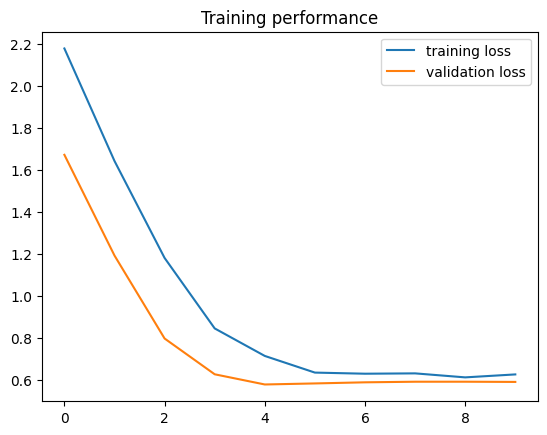

In [105]:
def adjust_lr(optimizer, epoch):
    if epoch < 1:
        lr = 3e-5
    
    elif epoch < 5:
        lr = 1e-4
    
    elif epoch < 8:
        lr = 1e-5
    else:
        lr = 6e-6
        
    for p in optimizer.param_groups:
        p['lr'] = lr
    return lr
        
train_loader = DataLoader(trainset, batch_size=256, shuffle=True)
val_loader = DataLoader(devset, batch_size=256, shuffle=False)
test_loader = DataLoader(testset, batch_size=256, shuffle=False)

model = VGGBinaryClassification()
loss_fn = nn.CrossEntropyLoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

training_loss, validation_loss, model = train(model, loss_fn, train_loader, val_loader, 
                                              lr_adjuster=adjust_lr, return_model=True, device=device, epochs=10)

plt.title('Training performance')
plt.plot(training_loss, label='training loss')
plt.plot(validation_loss, label='validation loss')
plt.legend()
plt.show()

In [106]:
print("Training report")
training_report = evaluate(trainset, model, device=device, batch_size=256)
print("Validation report")
validation_report = evaluate(devset, model, device=device, batch_size=256)
print("Test report")
test_report = evaluate(testset, model, device=device, batch_size=256)

Training report


100%|██████████| 4/4 [02:42<00:00, 40.60s/it]


              precision    recall  f1-score   support

           0      0.709     0.996     0.828       699
           1      0.833     0.050     0.094       301

    accuracy                          0.711      1000
   macro avg      0.771     0.523     0.461      1000
weighted avg      0.746     0.711     0.607      1000

Validation report


100%|██████████| 1/1 [00:38<00:00, 38.53s/it]


              precision    recall  f1-score   support

           0      0.731     1.000     0.845       174
           1      1.000     0.030     0.059        66

    accuracy                          0.733       240
   macro avg      0.866     0.515     0.452       240
weighted avg      0.805     0.733     0.629       240

Test report


100%|██████████| 2/2 [00:49<00:00, 24.56s/it]

              precision    recall  f1-score   support

           0      0.719     0.986     0.832       213
           1      0.625     0.057     0.105        87

    accuracy                          0.717       300
   macro avg      0.672     0.522     0.468       300
weighted avg      0.692     0.717     0.621       300



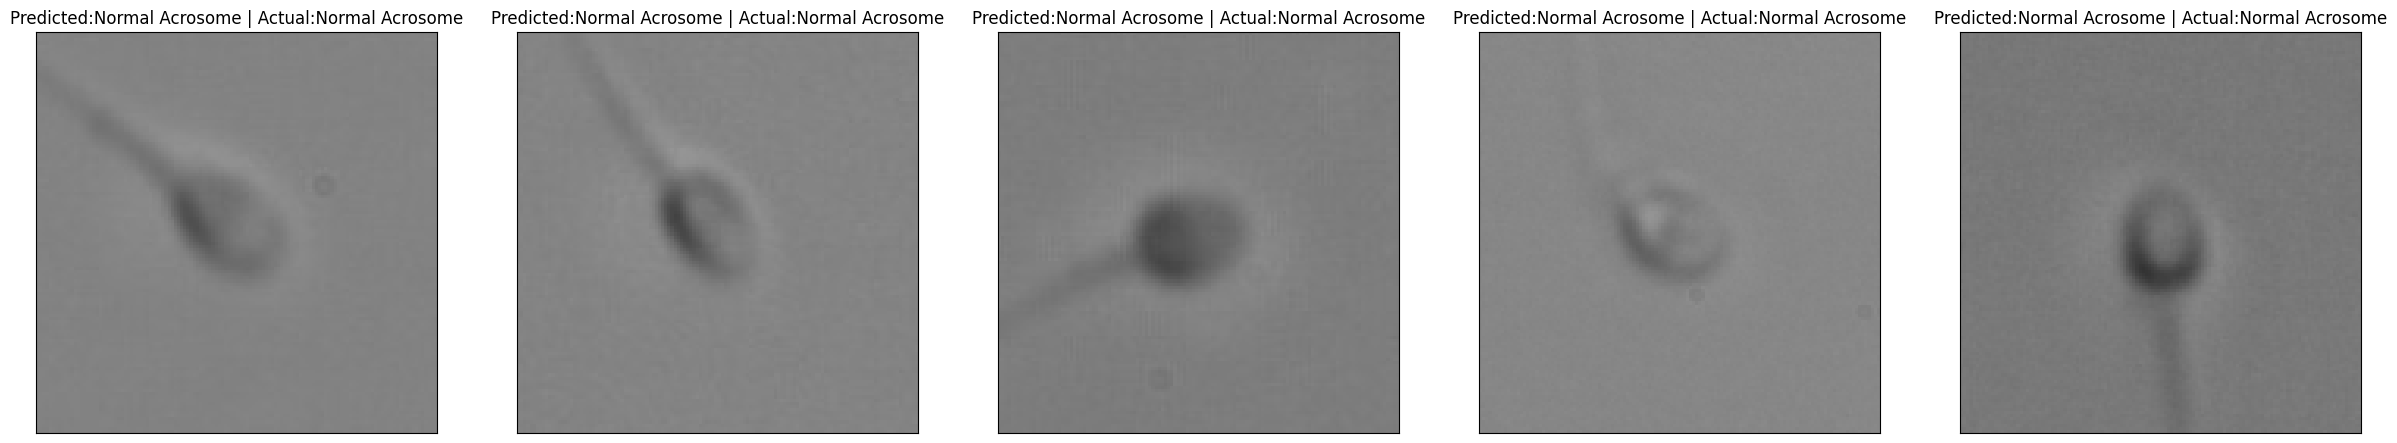

In [112]:
idx_to_labels = {0: "Normal Acrosome", 1: "Abnormal Acrosome"}
N=5
random_indices = np.random.randint(0, len(testset)-1, N)
random_samples = [testset[i] for i in random_indices]

fig, axs = plt.subplots(ncols=5, nrows=1, figsize=(30,30))

for i in range(N):
    sample = random_samples[i]
    image, label = sample
    # label = int(label
    category = idx_to_labels[label.item()]
    
    input_image = image.unsqueeze(0).to(device)
    model_output = model(input_image)
    prediction = torch.argmax(torch.softmax(model_output, -1)).item()
    predicted_category = idx_to_labels[prediction]

    axs[i].imshow(image.type(torch.int32).permute(1, 2, 0))
    axs[i].set(xticks=[], yticks=[], xticklabels=[], yticklabels=[])
    axs[i].set_title(f'Predicted:{predicted_category} | Actual:{category}')
plt.show()

In [ ]:
# saving the model
PATH = '/content/drive/MyDrive/AI Projects/Meta-learning vision project/Models/VGG16'
os.makedirs(PATH, exist_ok=True)
torch.save(model, PATH)

In [ ]:
# load model
model = torch.load(PATH)
model.eval()